In [3]:
import numpy as np
import cv2
from scipy.stats import chi2
from typing import Tuple, Dict, List
import glob

import sys

import json
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import utils as ut

import spectral as sp

In [4]:
def read_images(
        input_dir: str,
        mask: np.ndarray,
        homographies: Dict[str, List[List[float]]]
) -> Tuple[Dict[str, Dict[str, Dict[str, np.ndarray]]], Dict[str, Dict[str, Dict[str, np.ndarray]]]]:
    """
    Finds all .png files recursively in a given input directory. The images are loaded,
    a mask is applied to filter unwanted regions of the images and the images get
    warped based on the provided homographies.
    With this dictionary structure it can be assured that the images of one
    image set always go together.

    Args:
        input_dir: Input directory which contains .png images
        mask: Filter to mask out unwanted regions of all images at the same position
        homographies: Dictionary mapping the file name to the associated homography

    Returns:
        A tuple containing 2 dictionaries for the original and warped images.
        Each dictionary is structured as follows:
            {Folder Name (e.g. "valid-1-0"): {File Set Number (e.g. 0): {File Name (e.g. 0-B01): Image as array}}}
    """
    input_dir = os.path.abspath(input_dir)

    sorted_files = sorted(glob.glob(
        os.path.join(input_dir, '**', '*.png'),
        recursive=True
    ))

    original_images = {}
    warped_images = {}

    for file in sorted_files:
        folders, file_name = os.path.split(file)
        file_name = file_name.split('.')[0]
        folder_name = os.path.basename(folders)
        file_set = file_name.split('-')[0]

        if folder_name not in original_images and folder_name not in warped_images:
            original_images[folder_name] = {}
            warped_images[folder_name] = {}

        if file_set not in original_images[folder_name] and file_set not in warped_images[folder_name]:
            original_images[folder_name].update({file_set: {}})
            warped_images[folder_name].update({file_set: {}})

        img = cv2.imread(file)
        w, h, _ = img.shape
        img = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp
        original_images[folder_name][file_set].update({file_name: img}) #save the original

        homography = np.array(homographies[file_name]) #get homography

        warped_img = cv2.warpPerspective(img, homography, (w,h)) #warp the image using the given homography
        warped_images[folder_name][file_set].update({file_name: warped_img})

    return original_images, warped_images

MASK = 'data/mask.png'
IMAGE_FOLDER = 'data/validation/valid-1-0/'

mask = cv2.imread(MASK,0)
homographies = json.loads(open(IMAGE_FOLDER+'homographies.json','r').read())

#images = []

orig_images, warped_images = read_images(IMAGE_FOLDER, mask, homographies)

In [5]:
MASK = 'data/mask.png'
IMAGE_FOLDER = 'data/validation/valid-1-0/'

mask = cv2.imread(MASK,0)
homographies = json.loads(open(IMAGE_FOLDER+'homographies.json','r').read())

#images = []

orig_images = []
warped_images = []

for root, dirs, files in os.walk(IMAGE_FOLDER):
    for file in files:
        if file.endswith('.png'):
            img = cv2.imread(os.path.join(root,file))
            w,h,_ = img.shape
            res = cv2.bitwise_and(img,img,mask=mask) #apply the mask to remove the timestamp
            orig_images.append(res) #save the original

            w,h,_ = img.shape
            name = file.replace('.png','')
            M = np.array(homographies[name]) #get homography

            res = cv2.warpPerspective(res, M, (w,h)) #warp the image using the given homography
            warped_images.append(res)

In [6]:
def display_images(images, figsize=None, resize_dim=(200, 200)):
    if figsize: row, col = figsize
    else: row, col = 1,1
        
    fig, axs = plt.subplots(row, col, figsize=figsize)
    if row>1 or col>1: axs = axs.flatten()
    else: axs = [axs]
    fig.set_figwidth(20)
    fig.set_figheight(15)
    
    for img, ax in zip(images, axs):
        ax.imshow(cv2.resize(img, resize_dim), interpolation='nearest')
        
    plt.show()

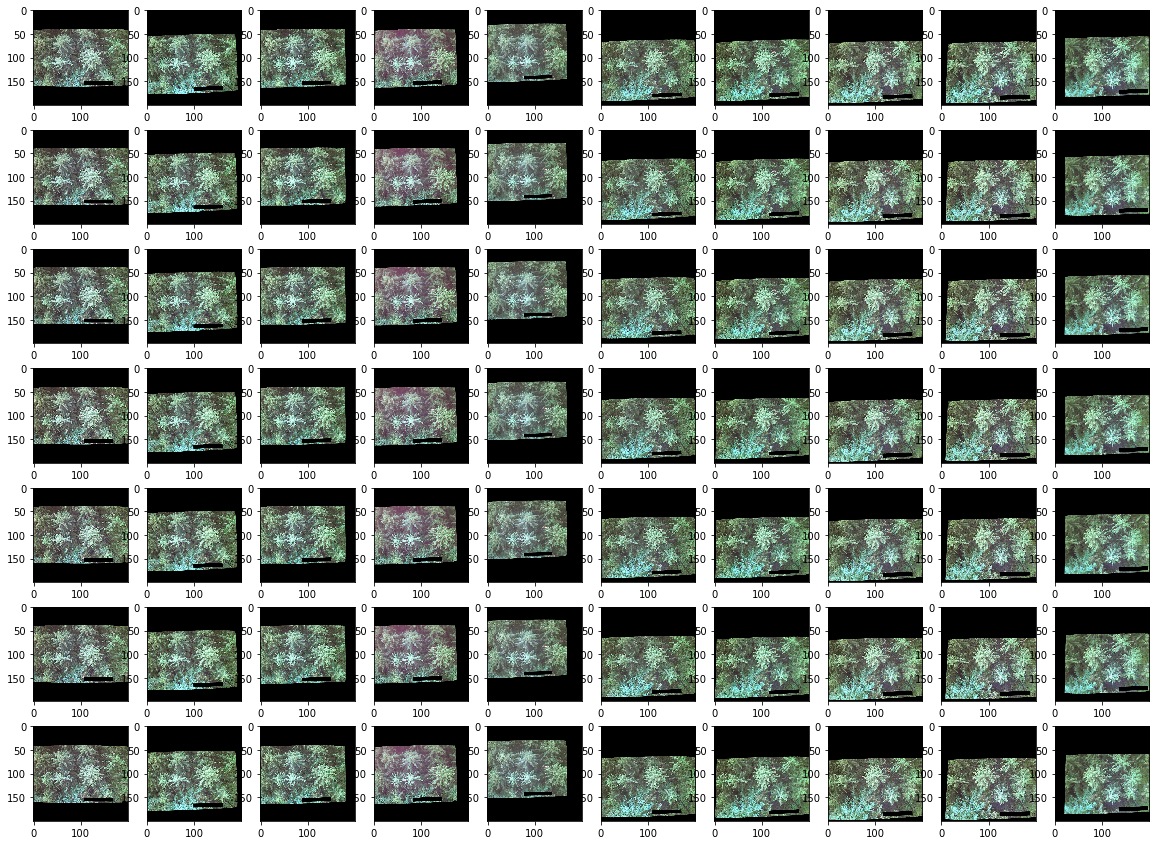

In [7]:
display_images(np.array(warped_images), figsize=(7,10), resize_dim=(200,200))
#display_images(np.array(orig_images), figsize=(7,10), resize_dim=(200,200))

In [18]:
def integrate(images: np.ndarray):

    integrated_images = []
    mask_images = []
    """
    This is going through all the sets of images,True
    where images[0] represents 10 images in a numpy array
    """
    for i in range(len(images)): 
        integral = np.zeros((images[0].shape[1:]), np.float64)
        mask = np.zeros((images[0].shape[1:]), np.float64)
        mask = mask[:,:,0]
        mask_ = np.copy(mask)

        for j in range(len(images[i])):
            integral += images[i][j]
            
            height, width, _ = images[i][j].shape
            for x in range(height):
                for y in range(width):
                    if all(images[i][j][x,y] == [0,0,0]):
                        mask[x,y] += 1
        
        x,y = mask.shape
        for n in range(x):
            for m in range(y):
                if mask[n,m] == 0:
                    mask_[n,m] = 1
                else:
                    mask_[n,m] = 0

        mask_images.append(mask_)
        integral /= len(images[i]) #np.divide(integral, divider, out=np.zeros_like(integral), where=divider!=0)
        integral=cv2.normalize(integral, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        integrated_images.append(integral)

    return integrated_images , mask_images

In [9]:
def color_check(image: np.ndarray):
    height, width = image.shape[:2]
    cc = np.zeros(image.shape, np.float64)
    for y,x in zip(range(height),range(width)):
        if all(image[x,y] != [0,0,0]):
            cc[x,y]=[0,0,0]
    return np.array(cc)


In [10]:
def crop_image(image):

    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _,thresh = cv2.threshold(grayscale,0,255,cv2.THRESH_OTSU)

    bbox = cv2.boundingRect(thresh)
    x,y,w,h = bbox
    
    return x,y,w,h
    #plt.imshow(grayscale[y:y+h,x:x+w], cmap='gray')

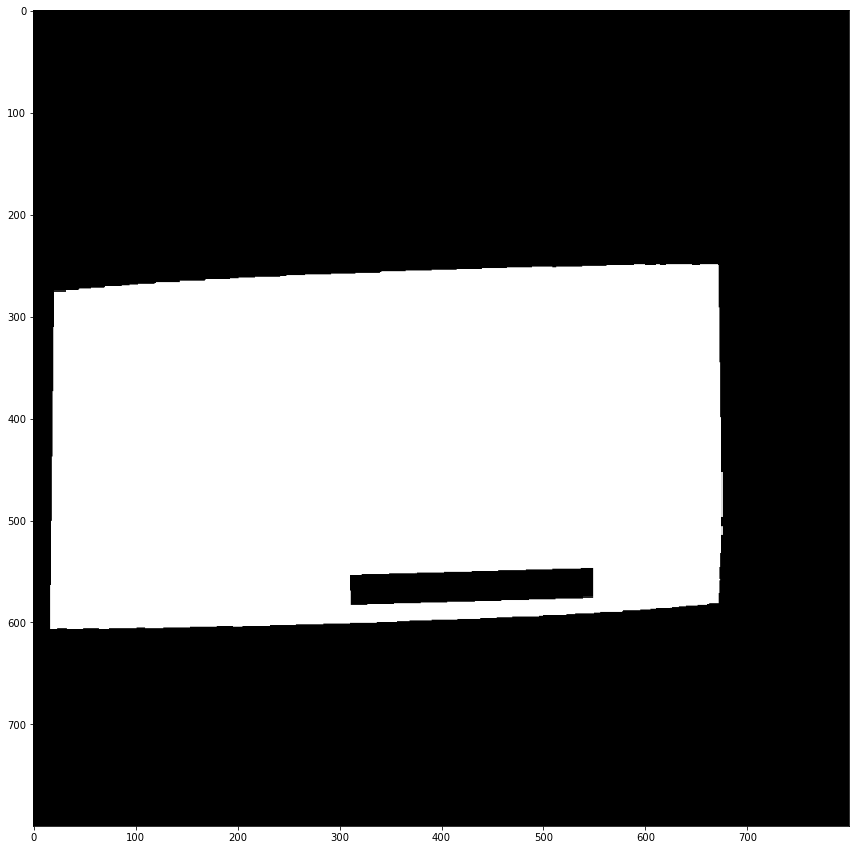

In [19]:
np.set_printoptions(threshold=sys.maxsize)

integrated_images, mask_images = integrate(np.array_split(warped_images,10))

int_img = [integrated_images[0]]

m_img = [cv2.cvtColor(np.float32(mask_images[0]),cv2.COLOR_GRAY2BGR)]

#display_images(np.array(int_img), resize_dim=(800,800))
display_images(np.array(m_img), resize_dim=(800,800))

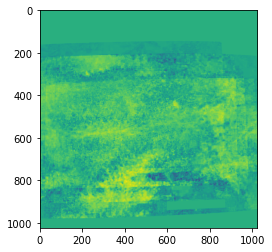

In [13]:
rxvals = []

for img in integrated_images:
    rxvals.append(sp.rx(img))

nbands = integrated_images[0].shape[-1]
P=chi2.ppf(0.99999, nbands)

#v=plt.imshow(1*(rxvals[0]>P))
v = plt.imshow(np.log(rxvals[0]))
#print(rxvals[0])

In [14]:
#test_img = orig_images[0]

#fig = plt.figure(figsize=(9,9))
#plt.imshow(test_img)

In [15]:
def rxd(img: np.ndarray) -> np.ndarray:
    """
    Implementation of the Reed-Xiaoli detector. Calculates a score for each pixel as the
    Mahalanobis distance between the pixel and the background.

    Args:
        img: Image in the shape Height x Width x 3

    Returns:
        Numpy array with the Mahalanobis distance of each pixel with shape Height x Width of the input image
    """
    h, w, c = img.shape

    # Calculate Mean Vector
    mean_vec = np.mean(img, axis=(0, 1))

    # Calculate Covariance Matrix
    img_tmp = img.copy()
    img_tmp = img_tmp.astype('float32') - mean_vec
    img_tmp = img_tmp.reshape(-1, 3)
    cov_mat = (img_tmp.T @ img_tmp) / (img_tmp.shape[0] - 1)

    # Initialize Result Matrix
    D_rx = np.zeros((h,w))

    # Calculate Mahalanobis distance
    for i in range(h):
        for j in range(w):
            r = img[i,j]
            r_normal = r - mean_vec
            D_rx[i,j] = r_normal.T @ np.linalg.inv(cov_mat) @ r_normal

    return D_rx

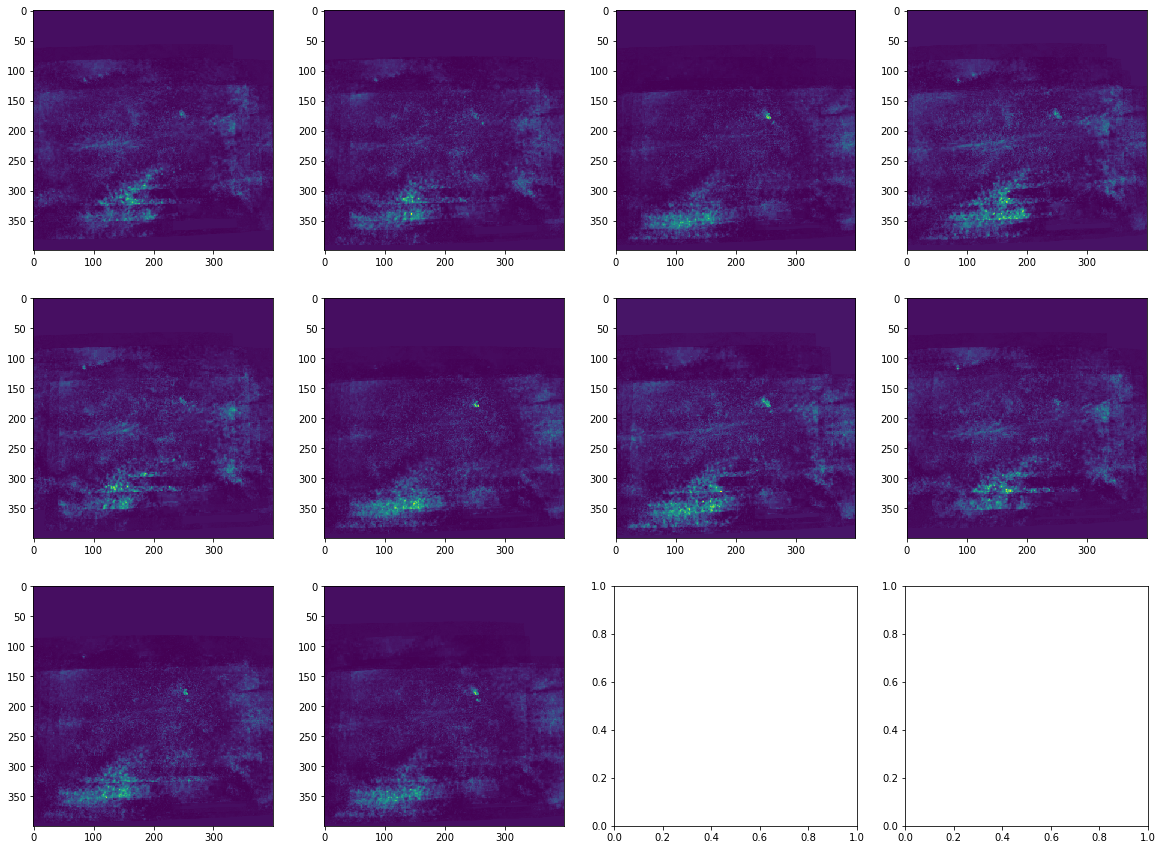

In [16]:
anomaly_images = []

for img in integrated_images:
    anomaly_images.append(rxd(img))

display_images(np.array(anomaly_images), figsize=(3,4), resize_dim=(400,400))

#test_rxd = rxd(test_img)

In [17]:
def anomaly_mask(rxd_arr: np.ndarray, conf_coef: float=0.999, verbose: bool=False) -> np.ndarray:
    """
    Calculates a threshold for the values of the RX-detector in order to find
    only the most extreme anomalies which have a higher RX-score than conf_coef %
    of the values in the array. All values below this threshold are set to 0.
    If verbose is True, then the cumulative probability density of the rxd_array is
    printed alongside the returned mask.

    Args:
        rxd_arr: Output of the rxd function -> RX-Values of an image
        conf_coef: Confidence coefficient to control the cutoff for actual anomalies
        verbose: Control whether plots should be created or not

    Returns:
        Anomaly mask where all pixels except anomaly are set to 0
    """

    rxd_sorted = np.sort(rxd_arr.flatten())
    prob = 1. * np.arange(len(rxd_sorted)) / (len(rxd_sorted) - 1)

    threshold_idx = np.argwhere(prob > conf_coef)[0][0]
    threshold = rxd_sorted[threshold_idx]

    mask = rxd_arr > threshold

    rxd_arr[~mask] = 0

    if verbose:
        fig = plt.figure(figsize=(15,7))
        ax1 = fig.add_subplot(121)
        ax1.plot(rxd_sorted, prob)
        ax1.title.set_text("CDF of RX-Values")
        ax1.set_xlabel("RX Value")
        ax1.set_ylabel("Cumulative Probability")

        ax2 = fig.add_subplot(122)
        ax2.imshow(rxd_arr)
        ax2.title.set_text("Anomaly Mask")

    return rxd_arr

rx_mask = anomaly_mask(test_rxd, 0.999, False)

NameError: name 'test_rxd' is not defined

In [ ]:
rxd_ = []

for img in anomaly_images:
    rxd_.append(anomaly_mask(img,0.999,False))

In [ ]:
def get_bounding_boxes(image,mask):
    res = cv2.bitwise_and(image,image,mask = mask)
    contours = cv2.findContours(res.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)[0]
    if len(contours):
        detected_anomalies_bb = np.stack([cv2.boundingRect(c) for c in contours])
    else:
        detected_anomalies_bb = np.zeros((0,4))
    
    return detected_anomalies_bb, contours

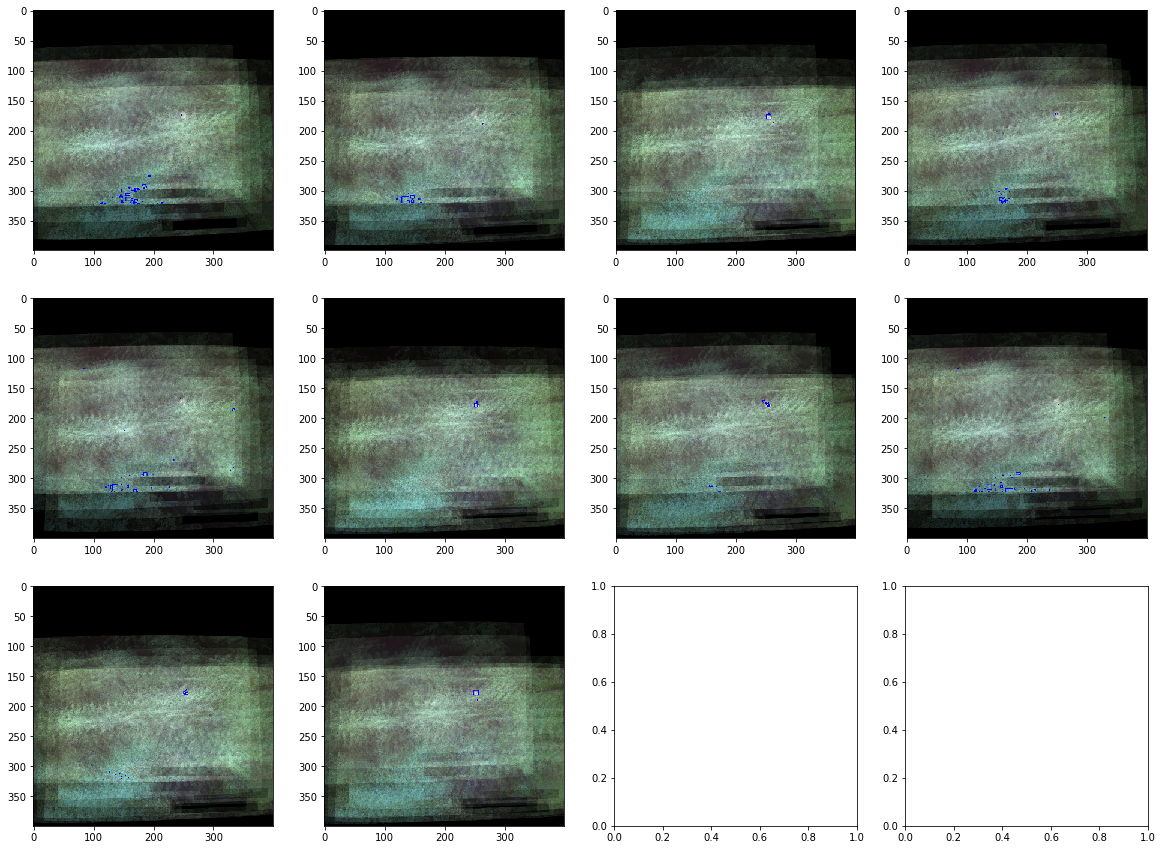

In [ ]:
#see original images
#display_images(np.array(integrated_images), figsize=(3,4), resize_dim=(400,400))

points_ = []

for img in rxd_:
    b,c = get_bounding_boxes(img,mask)
    points_.append(b)


images_result = []

for z in range(len(points_)):
    tmp = integrated_images[z].copy()
    for cntr in points_[z]:
        x,y,w,h = cntr[0],cntr[1],cntr[2],cntr[3]
        cv2.rectangle(tmp, (x, y), (x+w, y+h), (0, 0, 255), 2)
    images_result.append(tmp)

display_images(np.array(images_result), figsize=(3,4), resize_dim=(400,400))

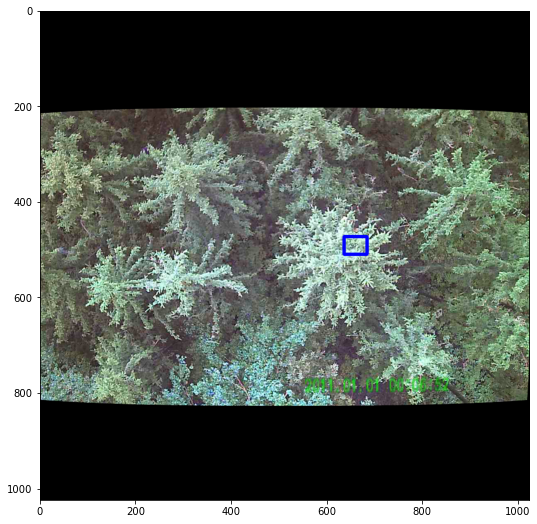

In [ ]:
with open(os.path.join(IMAGE_FOLDER, 'labels.json'), 'r') as label_file:
    gtlabels = json.load(label_file)

val_img = cv2.imread('data/validation/valid-1-0/3-B01.png')

def add_bounding_boxes(
        img: np.ndarray,
        gtlabels: List[List[int]],
        rgb_color: Tuple[int] = (0, 0, 255),
        thickness: int = 5
) -> np.ndarray:
    """
    Adds the given bounding boxes to an image. These bounding boxes are
    only aligned for the center image!

    Args:
        img: Image to which bounding boxes should be added
        gtlabels: Bounding boxes from a labels.json file
        rgb_color: Tuple representing the RGB color of the box
        thickness: Thickness of the box line

    Returns:
        Image with an overlayed bounding boxes
    """
    for bb in gtlabels:
        x, y, w, h = bb
        img = cv2.rectangle(
            img=img,
            pt1=(x,y),
            pt2=(x+w, y+h),
            color=rgb_color,
            thickness=thickness
        )

    return img

plt.figure(figsize=(9,9))
plt.imshow(add_bounding_boxes(val_img, gtlabels))